In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
df_prob2 = pd.read_csv('prob_of_detection_camp2.csv')
print(df_prob2)

     Unnamed: 0     kepid kepoi_name   kepler_name koi_disposition  koi_depth  \
0             9  10910878  K00757.01  Kepler-229 c       CONFIRMED     4914.3   
1            10  11446443  K00001.01    Kepler-1 b       CONFIRMED    14231.0   
2            11  10666592  K00002.01    Kepler-2 b       CONFIRMED     6674.7   
3            12   6922244  K00010.01    Kepler-8 b       CONFIRMED     9145.7   
4            37  11138155  K00760.01           NaN       CANDIDATE     9802.0   
5            41   9579641  K00115.01  Kepler-105 b       CONFIRMED      601.6   
6            45  11414511  K00767.01  Kepler-670 b       CONFIRMED    16814.0   
7            57  11812062  K00776.01  Kepler-673 b       CONFIRMED     5226.5   
8            58  11818800  K00777.01           NaN       CANDIDATE     6256.0   
9            65  11960862  K00782.01  Kepler-677 b       CONFIRMED     2793.3   
10           66  12020329  K00783.01  Kepler-678 b       CONFIRMED     3001.0   
11           72   3246984  K

In [20]:
#origninally had this dataset with mass information for change in period calculation but discarded this section
#df_confirmed_masses = pd.read_csv('compositepars.csv', skiprows=12)

In [21]:
#calculating transit time in July with a constant period model
#using error propagation to figure out the Kepler errors in July
dict_july_transits = {}
for index, row in df_prob2.iterrows():
    period = row['koi_period']
    perioderr1 = row['koi_period_err1']
    first_epoch_time = row['koi_time0bk']
    T0 = 2458679.5 - 2454833.0             #July 15th, 2019 - Jan 1st, 2009 (units BKJD- days from Jan 1st 2009)
    T0_err1 = row['koi_time0bk_err1']
    
    k=1
    #getting counts for how many epochs have occured from initial epoch to July 15th, 2019
    while ((first_epoch_time + period*k) <= T0):
        k+=1
    E = k-1
    
    #finding transit uncert with kepler
    C = first_epoch_time + period*E  
    delta_C = np.sqrt(T0_err1**2 + (perioderr1*E)**2)
    delta_C *= 1440
    
    df_prob2.at[index, 'Transit_uncert'] = delta_C  #in minutes
    df_prob2.at[index, 'Constant_period_transit_time'] = C
    df_prob2.at[index, 'Epoch_num_july19'] = E
    dict_july_transits[row['kepoi_name']] = delta_C 

In [22]:
df_transit_uncert = pd.DataFrame.from_dict(dict_july_transits, orient='index')
print(df_transit_uncert.isnull().sum())  #counting number of nan values for transit uncert

0    4
dtype: int64


In [23]:
#looking at orbital decay for all of these detectable planets using eqn from Patra et al.'s 2017 paper
dict_change_in_p = {}
for index, row in df_prob2.iterrows():
    radius = row['koi_prad']                        #in radius of earth
    semi_axis_srad = row['koi_sma']*214.93946938362 #now in solar radii
    mass_star = row['koi_smass']
    mass_star_earthm = mass_star*334672.021419      #now in earth masses
    change_p_lst = []
    #trying different Q's
    for i in range(3, 8):
        if (radius >= 8.0):  
            #treat as a jupiter sized mass 
            #317.8 is mass of jupiter in earth masses
            change_p = (-27*np.pi) / (2*(float(1*10**i))) * (317.8 / mass_star_earthm)*(row['koi_srad'] / semi_axis_srad)**5
            change_p_lst.append(change_p)
        else:
            #M_planet = (radius / 1)**(2.06)  #this is when we used mass radius relationship to calculate mass
            change_p = (-27*np.pi) / (2*(float(1*10**i))) * (317.8 / mass_star_earthm)*(row['koi_srad'] / semi_axis_srad)**5
            change_p_lst.append(change_p)
            
    df_prob2.at[index, 'change_p'] = change_p_lst[0]
    dict_change_in_p[row['kepoi_name']] = change_p_lst       

In [24]:
df_change_p = pd.DataFrame.from_dict(dict_change_in_p, orient='index')

In [25]:
#calculating times of transit based on an orbital decay model in July 2019
for index, row in df_prob2.iterrows():
    C_transits = row['Constant_period_transit_time']
    T0 = row['koi_time0bk']                           #initial time of transit (days after Jan 1st)
    period = row['koi_period']
    change_p = row['change_p']
    N = row['Epoch_num_july19']                       #N is number of transits after inital transit in July 2019
    Tn = T0 + N*period + 0.5*(N**2)*change_p*period   #(chance_p*period = change in period in one orbit)
    df_prob2.at[index, 'decay_transit_in_july19'] = Tn
    df_prob2.at[index, 'Transit_difference'] = (C_transits - Tn)*1440

     Unnamed: 0     kepid kepoi_name  kepler_name koi_disposition  koi_depth  \
2            11  10666592  K00002.01   Kepler-2 b       CONFIRMED     6674.7   
74          507  10232123  K01075.01          NaN       CANDIDATE     4702.6   
88          606   9941662  K00013.01  Kepler-13 b       CONFIRMED     4590.6   
351        6152   5986270  K05220.01          NaN       CANDIDATE      456.6   
361        6609   7107567  K05353.01          NaN       CANDIDATE     6945.8   
372        7346   4150611  K03156.01          NaN       CANDIDATE     1112.0   
389        8116   9944201  K07259.01          NaN       CANDIDATE    22528.0   

     koi_duration  koi_prad  koi_period  koi_period_err1         ...          \
2         3.88864     16.10    2.204735     4.300000e-08         ...           
74        1.94050     18.66    1.343768     3.200000e-07         ...           
88        3.16877     21.42    1.763588     4.200000e-08         ...           
351       1.72370     18.39    1.534680

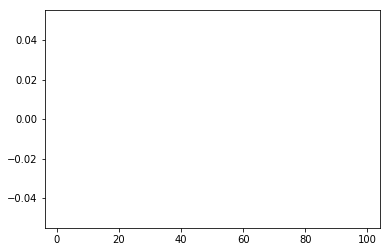

"\ndf_prob9 = df_prob2[df_prob2['kepoi_name'] == 'K00977.01'] #bad\n#print(df_prob2)\ndf_prob9 = df_prob2[df_prob2['kepoi_name'] == 'K07430.01']  #good\nprint(df_prob9)\n#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K00971.01'] #bad\n#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K01140.01']\n#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K05220.01'] #keep\n#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07791.01']\n#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07791.01']\n#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07100.01']\n#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K05157.01'] #toss this one\n\noutliers = df_prob2[df_prob2['Transit_difference'] >= 2000]\n"

In [26]:
#removing some planets that were falsely labelled 
df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K05129.01']
df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K05157.01'] 
testing_vals = ['K00002.01', 'K00013.01', 'K01075.01', 'K03156.01', 'K05220.01', 'K05353.01', 'K07259.01']
df_prob2 = df_prob2[(df_prob2['kepoi_name']).isin(testing_vals)]
print(df_prob2)
plt.hist(df_prob2['Transit_difference'], np.arange(1, 100, 1))
plt.show()

#print(np.max(df_prob2['Transit_difference']))
#array1 = np.where(df_prob2['Transit_difference'] == 15639.551953817572)
#print(array1)
#print(df_prob2.iloc[array1[0][0]])

'''
df_prob9 = df_prob2[df_prob2['kepoi_name'] == 'K00977.01'] #bad
#print(df_prob2)
df_prob9 = df_prob2[df_prob2['kepoi_name'] == 'K07430.01']  #good
print(df_prob9)
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K00971.01'] #bad
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K01140.01']
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K05220.01'] #keep
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07791.01']
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07791.01']
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07100.01']
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K05157.01'] #toss this one

outliers = df_prob2[df_prob2['Transit_difference'] >= 2000]
'''

In [27]:
import batman 
from scipy.interpolate import interp1d

In [28]:
#finding the tess uncertainty the same way as in the batman lightcurve notebook
for index, row in df_prob2.iterrows():
    M_star = row['koi_smass']
    Period = row['koi_period']
    a_axis_au = row['koi_sma']
    radius_p = row['koi_prad']
    radius_s = row['koi_srad']
    
    a_axis_stellar_r = a_axis_au*214.93946938362 / radius_s
    bat_params = batman.TransitParams()
    bat_params.t0 = 0.
    bat_params.per = Period
    bat_params.rp = radius_p / 109.489447246618 / radius_s    #planet radius (in units of stellar radii) #converting from R_earth to R_star
    bat_params.a = a_axis_stellar_r                           #semi-major axis (in units of stellar radii)
    bat_params.inc = 90 #row['koi_incl']
    bat_params.ecc = row['koi_eccen']
    bat_params.w = 90 #row['koi_longp']                       #longitude of periastron (in degrees)
    bat_params.u = [0.2075, 0.3785]
    bat_params.limb_dark = "quadratic"
    
    num_transits = int(30.0 / Period)
    
    if (num_transits == 0):
        two_min_x = np.arange(-Period/2, Period/2, 0.00138889)
    else:
        two_min_x = np.arange(-Period/2, Period/2, 0.00138889/num_transits)
        
    b_model = batman.TransitModel(bat_params, two_min_x, supersample_factor=7, exp_time=0.00138889) 
    flux = b_model.light_curve(bat_params)
    
    
    
    t_contam_ratio = 1 / (1 + row['tess_contam_ratio'])
    flux = flux*(row['kep_contam_ratio'])   #TAKE OUT LATER
    #flux = flux*t_contam_ratio            #ADD BACK IN LATERRRRR  
    
    #figuring out the transit duration in days (koi_duration is in hrs)
    duration = row['koi_duration'] / 24
  
    np.random.seed(6)
    noise = row['tot_noise']
    flux_uncert = np.random.normal(0, np.sqrt(15)*noise*10**(-6), len(two_min_x))    
    new_y = flux + flux_uncert
    
    '''
    plt.plot(two_min_x, new_y, 'g.', alpha=0.5)
    plt.plot(two_min_x, flux, 'b')
    plt.show()
    '''
    
    t0_array = np.linspace(-1*(duration+0.15), duration+0.15, 5000)
    t0_vs_chi2 = np.zeros(shape=(len(t0_array), 2))
    
    
    for time in range(len(t0_array)):
        a_axis_stellar_r = a_axis_au*214.93946938362 / radius_s
        bat_params = batman.TransitParams()
        bat_params.t0 = t0_array[time]
        bat_params.per = Period
        bat_params.rp = radius_p / 109.489447246618 / radius_s    #planet radius (in units of stellar radii) #converting from R_earth to R_star
        bat_params.a = a_axis_stellar_r                           #semi-major axis (in units of stellar radii)
        bat_params.inc = 90 #row['koi_incl']
        bat_params.ecc = row['koi_eccen']
        bat_params.w = 90    #row['koi_longp']                    #longitude of periastron (in degrees)
        bat_params.u = [0.2075, 0.3785]
        bat_params.limb_dark = "quadratic"
        
        b_model = batman.TransitModel(bat_params, two_min_x, supersample_factor=7, exp_time=0.00138889)#!0.02083
        flux = b_model.light_curve(bat_params)

        t_contam_ratio = 1 / (1 + row['tess_contam_ratio'])
        flux = flux*(row['kep_contam_ratio'])   #TAKE OUT LATER
        #flux = flux*t_contam_ratio            #ADD BACK IN LATERRRRR
        #tess_flux = tess_flux + (1-t_contam_ratio)      #ADD BACK IN LATERRRRR
        #print("flux from kep", flux)
        #print("flux from tess", flux)
       
        residuals = (flux - new_y)**2 
        chi2 = residuals / (np.sqrt(15)*noise*10**(-6))**2  
        
        t0_vs_chi2[time, 0] = t0_array[time]
        t0_vs_chi2[time, 1] = np.sum(chi2)
        
        #print(0.5*np.sum(chi2))
        
    
    likelihood_array = np.zeros(shape=(len(t0_vs_chi2)))
    transit_time = np.zeros(shape=(len(t0_vs_chi2)))
    normalized_likelihood = np.zeros(shape=(len(t0_vs_chi2)))
    
    for k in range (len(t0_vs_chi2)):
        #subtracting off the best value for chi2 so parabola has a min at zero and turning it into a likelihood
        likelihood_array[k] = (np.exp(-0.5*(t0_vs_chi2[k][1] - (np.min(t0_vs_chi2, axis=0))[1])))
        transit_time[k] = t0_vs_chi2[k][0]
        
    #finding the norm of the likelihoods 
    likelihood_array /= np.sum(likelihood_array)
    
    neg_val1 = 0.0
    neg_val2 = 0.0
    
    final_likelihood = np.cumsum(likelihood_array)
    first_dev = final_likelihood - 0.158 
    second_dev = final_likelihood - 0.842

    #print(first_dev)
    first_func = interp1d(transit_time, first_dev)

    #plt.plot(first_func.x, first_func.y, '-')
    #plt.show()
    
    second_func = interp1d(transit_time, second_dev)

    for index1 in range(len(first_dev)):
        if first_dev[index1] < 0:
            neg_val1 = first_dev[index1]
        else:
            break
    #print("neg_val", neg_val1)
    #print("pos_val", first_dev[index1])

    y1 = neg_val1
    y2 = first_dev[index1]

    x1 = transit_time[index1-1]
    x2 = transit_time[index1]
    #print([x1, x2])
    
    slope1 = (y1 - y2) / (x1 - x2)
    #print("slope", slope1)

    t_16 = -1*((y1 - 0) / slope1) + x1 
    #print("t_16", t_16)


    for index2 in range(len(second_dev)):
        if second_dev[index2] < 0:
            neg_val2 = second_dev[index2]
        else:
            break
    #print("neg_val2", neg_val2)
    #print("pos_val2", second_dev[index2])
    y84_1 = neg_val2
    y84_2 = second_dev[index2]

    x84_1 = transit_time[index2-1]
    x84_2 = transit_time[index2]
    #print([x84_1, x84_2])
    slope2 = (y84_1 - y84_2) / (x84_1 - x84_2)
    #print("top", (y84_1 - y84_2))
    #print("bottom", (x84_1 - x84_2))
    #print("slope2", slope2)
    #print((y84_1 - 0) / slope2)
    t_84 = -1*((y84_1 - 0) / slope2) + x84_1
    #print("t_84", t_84)

    std_dev_final = 0.5*(t_84 - t_16)

    #print(std_dev_final)
   
    df_prob2.at[index, 'batman_transit_uncert'] = std_dev_final
    
    

In [29]:
#print(df_prob2)
df_prob2.to_csv('HJ_df_new_mass_testing.csv')

In [30]:
import pandas as pd
import numpy as np

#loading dataframe produced from previous cells since that part of the code takes forever to run
df_prob2 = pd.read_csv('HJ_df_new_mass_testing.csv')
print(df_prob2)

   Unnamed: 0  Unnamed: 0.1     kepid kepoi_name  kepler_name koi_disposition  \
0           2            11  10666592  K00002.01   Kepler-2 b       CONFIRMED   
1          74           507  10232123  K01075.01          NaN       CANDIDATE   
2          88           606   9941662  K00013.01  Kepler-13 b       CONFIRMED   
3         351          6152   5986270  K05220.01          NaN       CANDIDATE   
4         361          6609   7107567  K05353.01          NaN       CANDIDATE   
5         372          7346   4150611  K03156.01          NaN       CANDIDATE   
6         389          8116   9944201  K07259.01          NaN       CANDIDATE   

   koi_depth  koi_duration  koi_prad  koi_period          ...            \
0     6674.7       3.88864     16.10    2.204735          ...             
1     4702.6       1.94050     18.66    1.343768          ...             
2     4590.6       3.16877     21.42    1.763588          ...             
3      456.6       1.72370     18.39    1.534680   

In [31]:
#finding the total uncertainty (tess and kepler combined)
#finding the ratio of transit difference to uncertainty to see what is detectable and what is not
for index, row in df_prob2.iterrows():
    Transit_uncert_linear = row['Transit_uncert']              #in minutes
    Transit_uncert_btman = row['batman_transit_uncert']*1440   #converting to minutes
    transit_diff = row['Transit_difference']
    
    total_uncert_mins = np.sqrt(Transit_uncert_linear**2 + Transit_uncert_btman**2)
    df_prob2.at[index, 'total_uncert_mins'] = total_uncert_mins
    
    ratio = transit_diff / total_uncert_mins
    df_prob2.at[index, 'transit_diff/total_uncert'] = ratio

In [32]:
print(df_prob2[['Transit_difference', 'total_uncert_mins', 'transit_diff/total_uncert']])

   Transit_difference  total_uncert_mins  transit_diff/total_uncert
0          103.461077           0.301178                 343.520803
1         3167.305619           1.576176                2009.487513
2          601.942068           0.325602                1848.704738
3       364468.815006           7.373692               49428.266474
4         3582.697763           9.622507                 372.324759
5        10201.760227          26.435849                 385.906276
6          434.514912           0.438051                 991.928212


In [33]:
#finding critical Q values that would make orbital decay detectable at 3-sigma
for index, row in df_prob2.iterrows():
    Transit_diff = row['Transit_difference']
    tot_uncert = row['total_uncert_mins']
    crit_Q = Transit_diff*1e3 / (3*tot_uncert)
    crit_Q = np.log10(crit_Q)
    df_prob2.loc[index, 'crit_Q'] = crit_Q

In [34]:
#discarding "planets" with radii greater than 30 earth radii
print(df_prob2)
df_prob2 = df_prob2[df_prob2['koi_prad'] <= 30]
df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K03794.01']
df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07430.01']
print('\n')

#the follow are planets that will be good candidates for orbital decay detection
#since a Q value of 5 is common
possible_dect_decay_df = df_prob2[df_prob2['crit_Q'] >= 5]
print(possible_dect_decay_df)
print(possible_dect_decay_df[['kepoi_name', 'koi_smass', 'tess_magnitude']])
 

   Unnamed: 0  Unnamed: 0.1     kepid kepoi_name  kepler_name koi_disposition  \
0           2            11  10666592  K00002.01   Kepler-2 b       CONFIRMED   
1          74           507  10232123  K01075.01          NaN       CANDIDATE   
2          88           606   9941662  K00013.01  Kepler-13 b       CONFIRMED   
3         351          6152   5986270  K05220.01          NaN       CANDIDATE   
4         361          6609   7107567  K05353.01          NaN       CANDIDATE   
5         372          7346   4150611  K03156.01          NaN       CANDIDATE   
6         389          8116   9944201  K07259.01          NaN       CANDIDATE   

   koi_depth  koi_duration  koi_prad  koi_period    ...     Transit_uncert  \
0     6674.7       3.88864     16.10    2.204735    ...           0.107091   
1     4702.6       1.94050     18.66    1.343768    ...           1.301654   
2     4590.6       3.16877     21.42    1.763588    ...           0.130909   
3      456.6       1.72370     18.39   

In [ ]:
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rc('xtick.major', size=6, pad=8)
plt.rc('xtick.minor', size=4, pad=5)
plt.rc('ytick.major', size=6, pad=8)
plt.rc('ytick.minor', size=4, pad=5)

In [ ]:
#making a histogram to show the spread in critical Q values
plt.hist(df_prob2['crit_Q'].dropna(), np.arange(-6, 10, 1), edgecolor='k', facecolor='w')  #, (np.arange(1, 6000, 1)))
plt.xlabel(r'$log_{10}(Q_{\star, c})$', fontsize=14)
plt.ylabel('Number of Systems', fontsize=14)
plt.gcf().subplots_adjust(left=0.17, bottom=0.17, right=0.94, top=0.94, wspace=0.0, hspace=0.0)
plt.savefig('Q_star_hist_assum_MJ.pdf', bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['axes.linewidth']=3
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rc('xtick.major', size=8, pad=8)
plt.rc('xtick.minor', size=6, pad=5)
plt.rc('ytick.major', size=8, pad=8)
plt.rc('ytick.minor', size=6, pad=5)

In [ ]:
#reading in the dataframe produced when we use the mass radius relationship to compute mass
#for the change in period rather than assuming a 1 jup mass for all planets

old_df = pd.read_csv('HJ_df_final_radiusmass_relation.csv')
old_df = old_df[old_df['kepoi_name']  != 'K03794.01']
old_df = old_df[old_df['kepoi_name']  != 'K07430.01']
old_df = old_df[old_df['koi_prad'] <= 30]

plt.hist(old_df['crit_Q'].dropna(), np.arange(-6, 10, 1), edgecolor='k', linewidth=2.0, facecolor='w') 
plt.xlabel(r'$\log_{10}(Q_{\star, c})$', fontsize=14)
plt.ylabel('Number of Systems', fontsize=14)
plt.gcf().subplots_adjust(left=0.17, bottom=0.17, right=0.94, top=0.94, wspace=0.0, hspace=0.0)
plt.savefig('Q_star_hist_mass_radius_relation.png', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
#adding crit Q values from the 1 Jup mass assumption df to the old df(based on mass-radius relationship)
#this is for the sole purpose of having one dataset with all the information for the paper
for index, row in old_df.iterrows():
    name = row['kepoi_name']
    #NOTE: tess uncert is the same as batman_transit_uncert but in minutes instead of days
    old_df.at[index, 'TESS_Uncert'] = (row['batman_transit_uncert'])*1440
    array = np.where(df_prob2['kepoi_name'] == name)
    new_row = df_prob2.iloc[array[0][0]]
    JupmassQ = new_row['crit_Q']
    old_df.at[index, 'Jup_mass_Q'] = JupmassQ

In [ ]:
table_for_paper = old_df[['kepoi_name', 'kepler_name', 'koi_period', 'koi_prad', 'koi_smass', 'tess_magnitude', 'Transit_uncert', 'TESS_Uncert', 'crit_Q', 'Jup_mass_Q']]
table_for_paper.rename(columns={'Transit_uncert': 'Kepler_uncert'}, inplace=True))

In [ ]:
#making a HJ table for the paper and the machine readable table
table_for_paper = table_for_paper.sort_values(by=['kepoi_name'])
table_for_paper = table_for_paper.round({'koi_period':6, 'koi_smass': 2, 'tess_magnitude': 2, 'Kepler_uncert':2, 'TESS_Uncert':2, 'crit_Q':2, 'Jup_mass_Q':2})
table_for_paper = table_for_paper.drop(['tess_magnitude'], axis=1)
print(table_for_paper)
table_for_paper.to_csv('HJ_final_table.csv', index = False, header=None)

In [ ]:
df_prob2.to_csv('HJ_df_final_all_Mjup_new_mass.csv')